In [1]:
import tensorflow as tf
import numpy as np
import math
import os
from tensorflow.python.framework import ops
import tflearn_dev
import Model
import matplotlib.pyplot as plt
%matplotlib inline  

In [7]:
trained_path = './Filter_Prune/log/rescale_fc_potential_lr_0.0001_wd_100_Sep_20_14_49/model/vali_0.853-3900'
sel_layer_names = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5', 'conv_6']


In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="3" 
tf_config=tf.ConfigProto() 
tf_config.gpu_options.allow_growth=True 
tf_config.gpu_options.per_process_gpu_memory_fraction=0.9
sess = tf.InteractiveSession(config=tf_config)

saver = tf.train.import_meta_graph(trained_path+'.meta')
saver.restore(sess, trained_path)
print('Model restored from ', trained_path)


INFO:tensorflow:Restoring parameters from ./Filter_Prune/log/rescale_fc_potential_lr_0.0001_wd_100_Sep_20_14_49/model/vali_0.853-3900
Model restored from  ./Filter_Prune/log/rescale_fc_potential_lr_0.0001_wd_100_Sep_20_14_49/model/vali_0.853-3900


In [9]:
variables = tf.global_variables()
variables[0:10]

[<tf.Variable 'global_step:0' shape=() dtype=int64_ref>,
 <tf.Variable 'conv_1/W:0' shape=(3, 3, 3, 128) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc1/W:0' shape=(128, 4) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc1/b:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc2/W:0' shape=(4, 128) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc2/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv_1/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv_2/W:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv_2/scale/fc1/W:0' shape=(128, 4) dtype=float32_ref>,
 <tf.Variable 'conv_2/scale/fc1/b:0' shape=(4,) dtype=float32_ref>]

In [30]:
var = [v for v in tf.global_variables() if v.name == 'conv_1/W:0'][0]
out_dim = weight.shape[-1]

In [51]:
def inner_fc(norm, W1, b1, W2, b2):
    out = np.matmul(norm, W1) + b1
    out = (abs(out) + out) / 2
    out = np.matmul(out, W2) + b2
    scale = 1 / (1 + np.exp(-out))
    return scale

In [42]:
layer_name = 'conv_1'
weight = [v for v in tf.global_variables() if v.name == layer_name+'/W:0'][0]
weight = weight.eval()
num_filter = weight.shape[-1]
ls = []
for out in range(0,num_filter):
    each_filter = weight[:,:,:,out]
    l = np.linalg.norm(each_filter.reshape(-1),ord=1)
    ls.append(l)

scale_fc_W1 = [v for v in tf.global_variables() if v.name == layer_name+'/scale/fc1/W:0'][0]
scale_fc_b1 = [v for v in tf.global_variables() if v.name == layer_name+'/scale/fc1/b:0'][0]
scale_fc_W2 = [v for v in tf.global_variables() if v.name == layer_name+'/scale/fc2/W:0'][0]
scale_fc_b2 = [v for v in tf.global_variables() if v.name == layer_name+'/scale/fc2/b:0'][0]



SyntaxError: invalid syntax (<ipython-input-60-eb35785f49f8>, line 1)

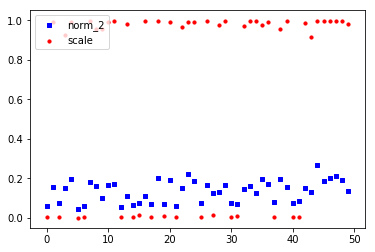

In [67]:
#plt.hist(ls)
scale = inner_fc(ls, scale_fc_W1.eval(), scale_fc_b1.eval(), scale_fc_W2.eval(), scale_fc_b2.eval())

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(range(0,50), ls[0:50], s=10, c='b', marker="s", label='norm_2')
ax1.scatter(range(0,50), scale[0:50], s=10, c='r', marker="o", label='scale')
plt.legend(loc='upper left');
plt.show()

In [72]:
weight_new = np.copy(weight)
scale = inner_fc(ls, scale_fc_W1.eval(), scale_fc_b1.eval(), scale_fc_W2.eval(), scale_fc_b2.eval())
scale = np.array(scale)

under_threshold = abs(scale) < 0.9
under_threshold_elem = np.zeros(weight.shape, dtype=bool)
under_threshold_elem[:,:,:,under_threshold] = True
weight_new[under_threshold_elem] = 0


In [76]:
weight_new[:,:,:,3]

array([[[ 0.0033489 , -0.00632355,  0.00267829],
        [ 0.00984757, -0.0034419 , -0.00912974],
        [-0.00625221, -0.00459417, -0.00937479]],

       [[ 0.0067835 ,  0.00358712,  0.01203875],
        [-0.01005409, -0.00420072,  0.00490256],
        [ 0.00819497, -0.00238205, -0.0072473 ]],

       [[ 0.0073459 ,  0.00532512, -0.00099793],
        [-0.00166094,  0.00516141,  0.00419927],
        [ 0.00274921, -0.00613075,  0.00215997]]], dtype=float32)

In [2]:
def _build_graph():
    global_step = tf.contrib.framework.get_or_create_global_step()
    batch_data = tf.placeholder(name='data_pl', dtype=tf.float32, shape=(5,)+(32,32,3))
    # Calculate logits using training data and vali data seperately
    logits = getattr(Model, 'rescale_fc')(batch_data, 100)

In [3]:
ops.reset_default_graph()
sess = tf.InteractiveSession()

pruned_model = './log/prune_model/rescale_fc_Prune_Test_lr_0.0001_wd_100_Sep_23_21_42'

_build_graph()
tflearn_dev.config.init_training_mode()
init = tf.global_variables_initializer()
sess.run(init)
#tflearn_dev.is_training(True)
saver = tf.train.Saver(tf.global_variables())
saver.restore(sess, pruned_model)
print('Pruned model restored from ', pruned_model)

INFO:tensorflow:Restoring parameters from ./log/prune_model/rescale_fc_Prune_Test_lr_0.0001_wd_100_Sep_23_21_42
Pruned model restored from  ./log/prune_model/rescale_fc_Prune_Test_lr_0.0001_wd_100_Sep_23_21_42


In [4]:
tf.global_variables()

[<tf.Variable 'global_step:0' shape=() dtype=int64_ref>,
 <tf.Variable 'conv_1/W:0' shape=(3, 3, 3, 128) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc1/W:0' shape=(128, 4) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc1/b:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc2/W:0' shape=(4, 128) dtype=float32_ref>,
 <tf.Variable 'conv_1/scale/fc2/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv_1/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv_2/W:0' shape=(3, 3, 128, 128) dtype=float32_ref>,
 <tf.Variable 'conv_2/scale/fc1/W:0' shape=(128, 4) dtype=float32_ref>,
 <tf.Variable 'conv_2/scale/fc1/b:0' shape=(4,) dtype=float32_ref>,
 <tf.Variable 'conv_2/scale/fc2/W:0' shape=(4, 128) dtype=float32_ref>,
 <tf.Variable 'conv_2/scale/fc2/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'conv_2/b:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'BatchNormalization/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'BatchNormalization/gamma:0' sha